##### Loading the desired libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from keras.models import Sequential
from keras.layers import Flatten ,Dropout,Dense,Activation
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers import Conv2D,GlobalAveragePooling2D,MaxPooling2D,ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


##### Loading the data
The data is stored in .p extension which is a pickle file.

`“Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream is converted back into an object hierarchy. Pickling (and unpickling) is alternatively known as “serialization”, “marshaling,” or “flattening” .`

Test and Training data can be downloaded from here : https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip

In [4]:
##Loading the Data
training_file ='train.p'
testing_file  ='test.p'

with open(training_file ,mode='rb') as f:
    train =pickle.load(f)

with open(testing_file ,mode='rb') as f:
    test =pickle.load(f)

x_train ,y_train =train['features'] ,train['labels']
x_test ,y_test   =test['features']  ,test['labels']

In [9]:
print(x_train.shape ,y_train.shape)
print(x_test.shape ,y_test.shape)

(39209, 32, 32, 3) (39209,)
(12630, 32, 32, 3) (12630,)


numpy.ndarray

In [4]:
##This csv contains the lables name of the signs
signs_classID =pd.read_csv('signnames.csv')
signs_classID.iloc[:5]

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [5]:
## unique classes stores the distinct labels
## unique_sign    stores the distinct classes labels
## unique_sign_counts stores the count of each label in the dataset

unique_classes,unique_sign ,unique_sign_counts=np.unique(y_train ,return_index =True ,return_counts=True)
unique_sign_counts

array([ 210, 2220, 2250, 1410, 1980, 1860,  420, 1440, 1410, 1470, 2010,
       1320, 2100, 2160,  780,  630,  420, 1110, 1200,  210,  360,  330,
        390,  510,  270, 1500,  600,  240,  540,  270,  450,  780,  240,
        689,  420, 1200,  390,  210, 2070,  300,  360,  240,  240],
      dtype=int64)

#### Data Plotting and Exploration

In [6]:
def plot_images():
    
    fig =plt.figure(figsize=(18,18))
    i=0
    for index in (unique_sign):
        #     ax.set_xticklabels([])
        #     ax.set_yticklabels([])
        #     ax.set_aspect('equal')
        img =x_train[index]
        plt.subplot(11,4,i+1)
        plt.imshow(img)
        plt.title( str(y_train[index])+'. '+signs_classID['SignName'][y_train[index]] )
        plt.axis('off')
        i =i+1
    plt.show()

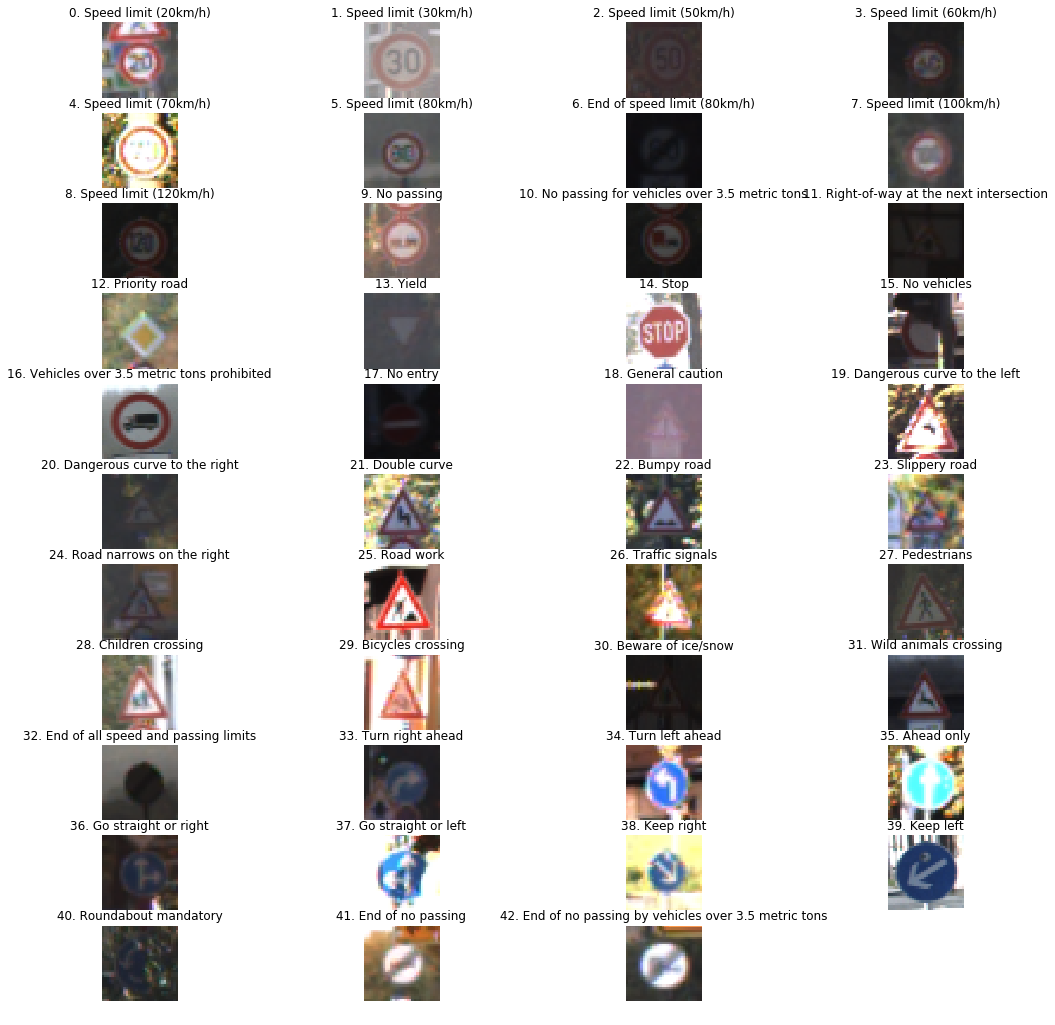

In [7]:
import matplotlib.image as img
plot_images()

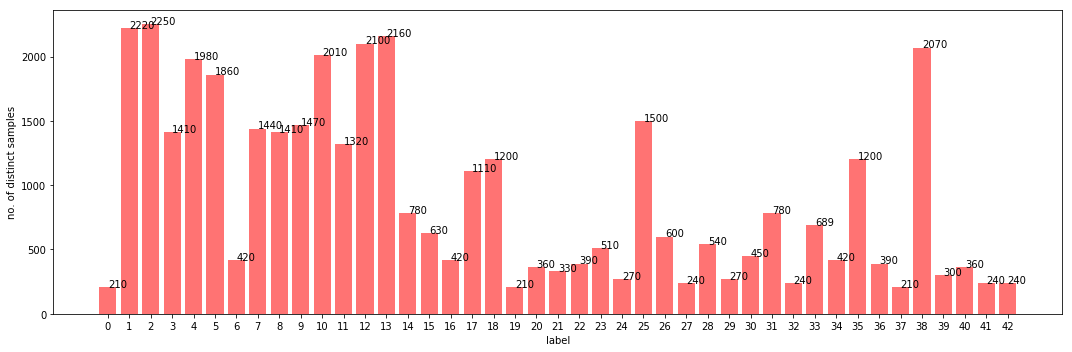

In [8]:
## plotting histogram

plt.figure(figsize=(15,5))
plt.bar(unique_classes,unique_sign_counts ,color='r' ,alpha=0.55)
plt.xlabel('label')
plt.ylabel('no. of distinct samples')
plt.xticks(unique_classes)
for a,b in zip(unique_classes ,unique_sign_counts):
    plt.text(a, b, str(b))
plt.tight_layout()
plt.show()

### Data Preprocessing

Preprocessing includes normalization ,filtering noise , rescaling , dimension reduction of the images for better accuracy.

Here we will be using open cv2 library to normalize the images between 50 to 200  through MIN-MAX scaling.

1.Normalization will mitigate differences due to light condition across the data set and will make the pixel intesity consistant.

2.Image Blurring or (Image Smoothing) :

Bluring is done to remove noise/unwanted features. Median blur was choosen because it works good in removing salt and pepper noise and produces best results when tested in comparison with averaging, gaussian blur or bilateralFilter.

understanding source : https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html


In [10]:
## preprocessing and scaling of data
import cv2
def normailze_blur(img):
    img  =cv2.normalize(img, img, 50,200 ,cv2.NORM_MINMAX)
    cv2.medianBlur(img, 3)                                 ##here 30% noise is added to the original dataset and applied median blur on it
    return img

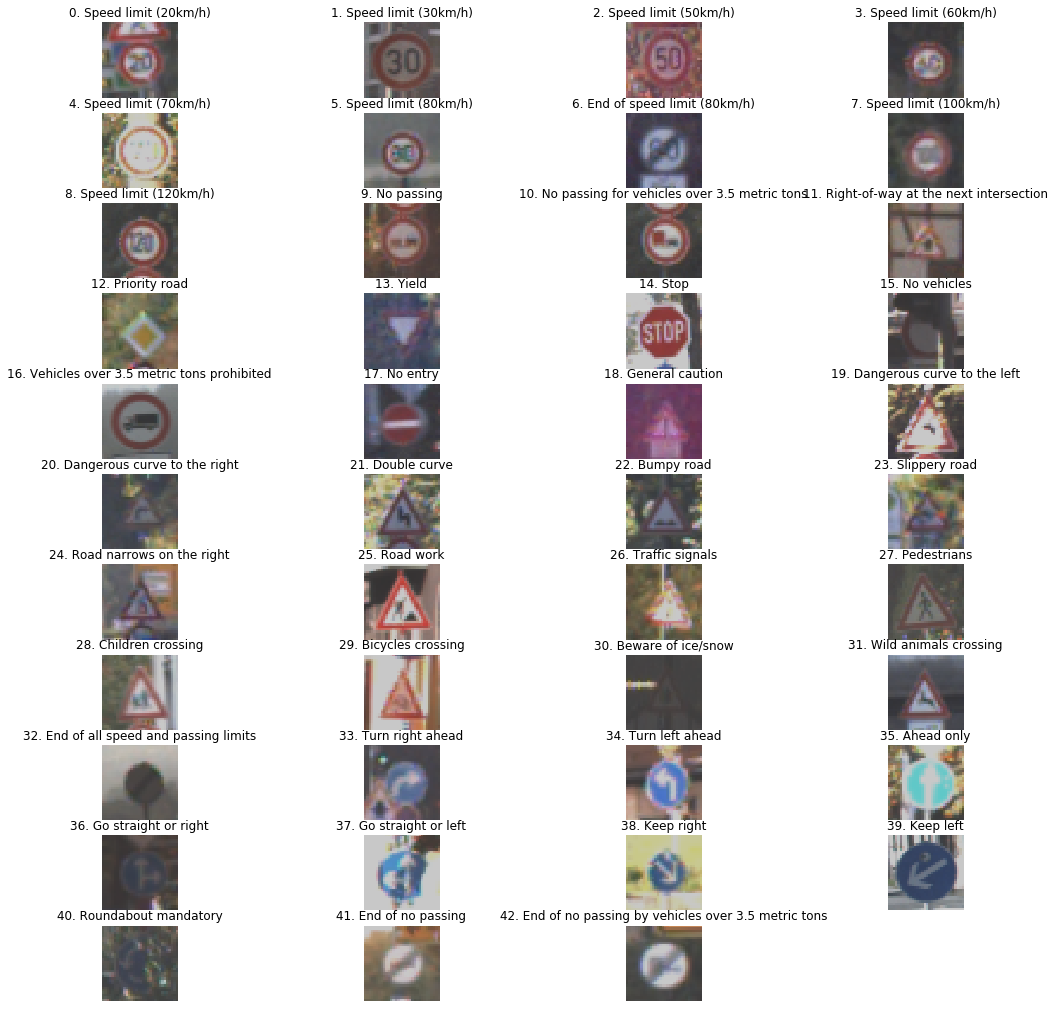

In [11]:
for i in range(len(x_train)):
    normailze_blur(x_train[i])

for i in range(len(x_test)):
    normailze_blur(x_test[i])

## Plotting the normalized dataset
## clearly the are normalized on a given scale.
plot_images()

##### Data Split into Train and Validation set

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

x_train ,y_train = shuffle(x_train,y_train)
x_test ,y_test =shuffle(x_test,y_test)

In [14]:
X_train , X_validation ,Y_train ,Y_validation =train_test_split(x_train,y_train,shuffle=True,random_state=0,test_size=0.3)

###### One-hot encoding of the output as needed in the CNN network

In [15]:
## one hot of the output
def one_hotencode(data):
    return np_utils.to_categorical(data,len(unique_classes))     # unique_classes here ,are 42

In [16]:
Y_train = one_hotencode(Y_train)
Y_validation =one_hotencode(Y_validation)
y_test =one_hotencode(y_test)

In [17]:
X_train.shape , X_validation.shape

((27446, 32, 32, 3), (11763, 32, 32, 3))

##### Defining the state of art (CNN) architecutre .

specifying the Conv2D layers , hidden ,flatten layers

In [18]:
## specifying the layers
model =Sequential()

model.add(Conv2D(32,(5,5),strides=(1,1) ,input_shape=(32,32,3)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(32 ,(5,5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
BatchNormalization(axis=-1)

model.add(Conv2D(64,(5,5)))
model.add(Activation('relu'))
BatchNormalization(axis =-1)

model.add(Conv2D(64 ,(5,5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
BatchNormalization()

model.add(Dense(1024))
model.add(Activation('relu'))

BatchNormalization()
model.add(Dropout(0.5))

model.add(Dense(len(unique_classes)))
model.add(Activation('softmax'))

In [19]:
model.compile(loss='categorical_crossentropy' ,optimizer=Adam() ,metrics=['accuracy'])

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        25632     
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
activation_3 (Activation)    (None, 8, 8, 64)          0         
__________

#### Data Augmentation
Data Augmentation is certainly a better way to get most out of the few or small dataset.

Here Data Augmentation can certainly improve the accuracy of the network as rotating the image to a certain angle will not change the defined 'knowldege' or quality of the physical nature of the images.

In [31]:
##Data augementation
##This network is paired using the Keras ImageDataGenerator to assist with image Augmentation through the learning process. 
##This can greatly improve the accuracy without the increase of labelled training examples.

gen = ImageDataGenerator(rotation_range=13 ,width_shift_range=0.12 ,shear_range=0.3 ,height_shift_range=0.12,zoom_range=0.2)
train_generator =gen.flow(X_train,Y_train,batch_size=32)

In [32]:
validate_gen =ImageDataGenerator()

validate_generator =validate_gen.flow(X_validation ,Y_validation)

#### Training the Model

In [33]:
model.fit_generator(train_generator ,steps_per_epoch=27446//20 ,epochs=7 ,
                    validation_data =validate_generator,validation_steps =11763//80)

Epoch 1/7
1372/1372 [==============================] - 431s 314ms/step - loss: 0.6071 - acc: 0.8181 - val_loss: 0.1444 - val_acc: 0.9571
Epoch 2/7
1372/1372 [==============================] - 338s 246ms/step - loss: 0.5659 - acc: 0.8326 - val_loss: 0.1289 - val_acc: 0.9626
Epoch 3/7
1372/1372 [==============================] - 350s 255ms/step - loss: 0.5410 - acc: 0.8418 - val_loss: 0.1372 - val_acc: 0.9592
Epoch 4/7
1372/1372 [==============================] - 364s 266ms/step - loss: 0.5271 - acc: 0.8472 - val_loss: 0.1320 - val_acc: 0.9598
Epoch 5/7
1372/1372 [==============================] - 356s 260ms/step - loss: 0.4794 - acc: 0.8613 - val_loss: 0.0973 - val_acc: 0.9707
Epoch 6/7
1372/1372 [==============================] - 366s 267ms/step - loss: 0.4717 - acc: 0.8639 - val_loss: 0.1238 - val_acc: 0.9643
Epoch 7/7
1372/1372 [==============================] - 345s 252ms/step - loss: 0.4621 - acc: 0.8683 - val_loss: 0.0873 - val_acc: 0.9741


In [34]:
x_test.shape ,y_test.shape

((12630, 32, 32, 3), (12630, 43))

###### Evaluating the accuracy metrics of the model

In [39]:
accuracy =model.evaluate(x_test,y_test)

12630/12630 [==============================] - 35s 3ms/step


In [40]:
accuracy

[0.20392892994311057, 0.9419635787523651]

In [42]:
print("Test Accuracy of the model --->" ,accuracy[1])

Test Accuracy of the model ---> 0.9419635787523651


In [72]:
np.unique(np.argmax(y_test,axis=1) ,return_index=True ,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=int64),
 array([ 28,   1,  26,  18,   7,   0,  47,  13,  14,  19,  15,  40,   9,
         36, 126,  39, 116,   4,   8,   5, 169,   2, 261,  41, 127,  17,
         38, 283, 149,  30,  87,  33, 271, 119, 254,  44,  35,  23,  12,
         58,  83, 255,   6], dtype=int64),
 array([ 60, 720, 750, 450, 660, 630, 150, 450, 450, 480, 660, 420, 690,
        720, 270, 210, 150, 360, 390,  60,  90,  90, 120, 150,  90, 480,
        180,  60, 150,  90, 150, 270,  60, 210, 120, 390, 120,  60, 690,
         90,  90,  60,  90], dtype=int64))

In [53]:
model.predict_classes(x_test[0:50])

array([ 5,  1, 21,  1, 17, 19, 16,  4, 18, 12,  5, 21, 38,  7,  8, 10,  7,
       25,  3,  9,  7, 12, 12, 37, 10, 17,  2, 12,  0, 18, 29, 10,  2, 31,
        5, 36, 13, 12, 26, 15, 11, 23,  3, 17, 35, 12,  4,  6,  4,  4],
      dtype=int64)

In [87]:
## Plotting the forst 50 x_test images for the verification

y_pred_labels =model.predict_classes(x_test[0:50])

#Converting onehot-encoded labels back to their numerical data
y_test_labels =np.argmax(y_test ,axis=1)

<function matplotlib.pyplot.show(*args, **kw)>

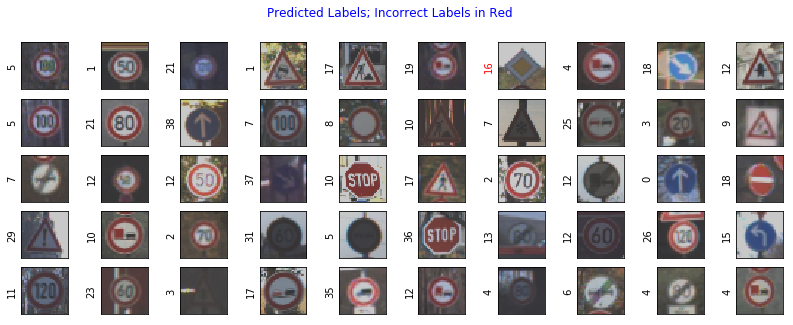

In [97]:
fig=plt.figure(figsize=(14,5))
for i in range(50):
    ax=fig.add_subplot(5,10,i+1 ,xticks=[] ,yticks=[])
    ax.imshow(x_train[i])
    ax.set_ylabel(y_pred_labels[i] ,color='black' if y_pred_labels[i]==y_test_labels[i] else 'red')
fig.suptitle('Predicted Labels; Incorrect Labels in Red' ,color='b' ,alpha=1.0)
plt.show